# 01-Data_Exploration

In [ ]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [ ]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

In [ ]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [ ]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [ ]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:11<00:33, 11.11s/it]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:15<00:14,  7.15s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:20<00:06,  6.09s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:24<00:00,  6.05s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [ ]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

File exists, loading data...
Training data loaded from pickle file.
Training data size: (2806456, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [ ]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [ ]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl exists, loading data...
Test data loaded from pickle file.
Testing data size: (744804, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [ ]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


STRATIFIED METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Model Poisoning Attack
print("--- Defining Model Poisoning Attack ---")
num_malicious_clients = 11  # about 33% of 33 clients
# Note: client_fn creates clients with string IDs, so we create a list of strings
malicious_client_ids = [str(i) for i in range(num_malicious_clients)]
poison_factor = 3.0 # Amplify weights to overpower other clients. A negative value could be used to flip the weights.

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Scaling weights by a factor of {poison_factor} for malicious clients after local training.")
print("--- Model Poisoning Attack Defined ---")


In [ ]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (280639, 39)
fl_y_train[0].value_counts():
Label
6     42854
4     32299
5     26796
2     24482
3     24314
1     24159
7     21524
13    19795
15    15920
14    12075
0      6573
17     5919
19     5317
18     4455
10     2697
23     2240
26     1846
8      1716
9      1709
25     1083
24      809
21      574
22      491
16      438
12      175
11      137
33       80
27       34
31       32
32       31
29       25
28       18
20       14
30        8
Name: count, dtype: int64
fl_y_train[0].unique(): [ 1  7  2  4  6 18  5 14 13  3  0 19 25 24 10 15 26 17  8 23 16 11 21  9
 33 12 22 32 27 30 28 29 31 20]

--- Client ID: 1 ---
fl_X_train[1].shape: (280639, 39)
fl_y_train[1].value_counts():
Label
6     42854
4     32299
5     26796
2     24482
3     24314
1     24158
7     21524
13    19795
15    15920
14    12074
0      6573
17     5920
19     5317
18     4454
10     2698
23     2240
26     1847
8      1716
9      1710
25     1083
24      809
2

Visualize Data Distribution

STRATIFIED Client

In [ ]:
#STRATIFIED Client

In [ ]:
#LEAVE_ONE_OUT

In [ ]:
#Half begign

In [ ]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


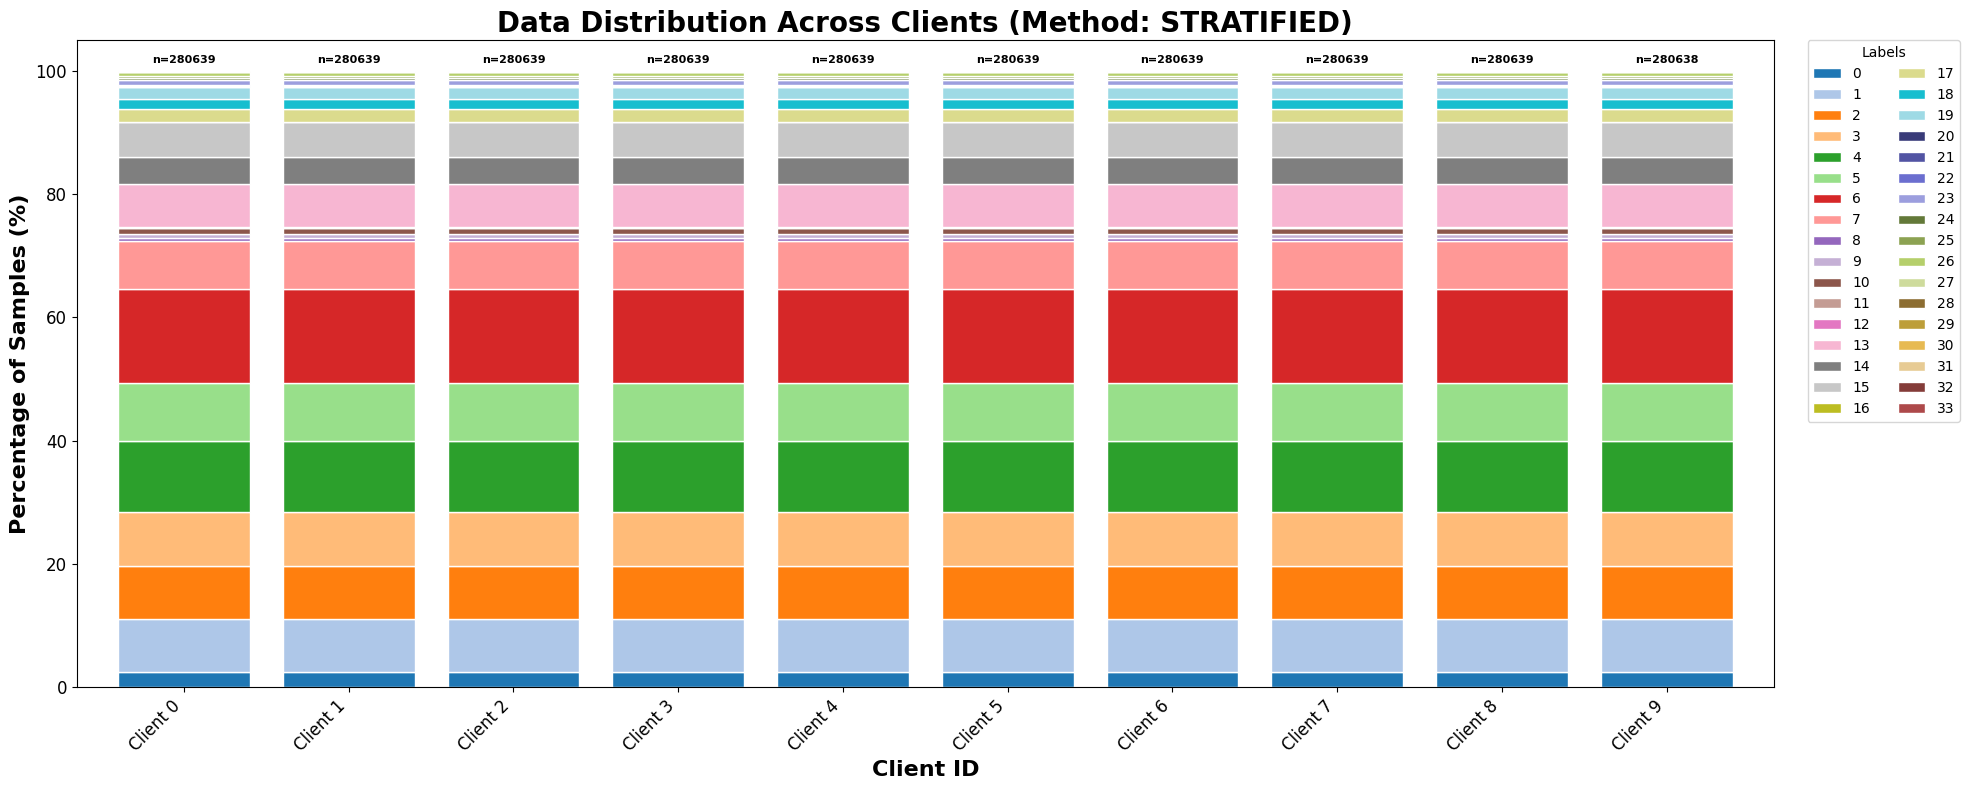

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [ ]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/STRATIFIED_Classifier-34_Clients-10


Convert the training dataset


In [ ]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [ ]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 10
NUM_ROUNDS: 10

Original training size: 2806389
Checking training data split groups
0 : X Shape (280639, 39) Y Shape (280639,)
1 : X Shape (280639, 39) Y Shape (280639,)
2 : X Shape (280639, 39) Y Shape (280639,)
3 : X Shape (280639, 39) Y Shape (280639,)
4 : X Shape (280639, 39) Y Shape (280639,)
5 : X Shape (280639, 39) Y Shape (280639,)
6 : X Shape (280639, 39) Y Shape (280639,)
7 : X Shape (280639, 39) Y Shape (280639,)
8 : X Shape (280639, 39) Y Shape (280639,)
9 : X Shape (280638, 39) Y Shape (280638,)

Checking testing data
X_test size: (744790, 39)
y_test size: (744790,)

Deploy Simulation


In [ ]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 787.3488761691207 -6.461840611824633e-05


#Federated Learning

Import the libraries and print the versions


In [ ]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [ ]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=1, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        
        weights = self.model.get_weights()
        
        # If the client is in the malicious list, poison the weights
        if self.cid in malicious_client_ids:
            print(f"Client {self.cid} is malicious, applying model poisoning...")
            poisoned_weights = [w * poison_factor for w in weights]
            return poisoned_weights, len(self.train_data), {}
            
        return weights, len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [ ]:
from flwr.server.strategy import FedProx

from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10, #10,
#         min_evaluate_clients=5, #5,
#         min_available_clients=10, #10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         #evaluate_metrics_aggregation_fn=weighted_average,
# )

# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

    strategy = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
    )

# Define FedProx strategy
strategy = FedProx(
    proximal_mu=1.0,  # Proximal term coefficient (tune as needed)
    fraction_fit=1.0,  # Fraction of clients to sample for training
    fraction_evaluate=1.0,  # Fraction of clients to sample for evaluation
    min_fit_clients=NUM_OF_CLIENTS,  # Minimum number of clients for training
    min_evaluate_clients=NUM_OF_CLIENTS,  # Minimum number of clients for evaluation
    min_available_clients=NUM_OF_CLIENTS,  # Minimum number of available clients
    evaluate_fn=get_evaluate_fn(server_model),
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout



Deploy simulation... Method = STRATIFIED - Individual (34) Classifier
Number of Clients = 10

Writing output to: train_size-2806456/STRATIFIED_Classifier-34_Clients-10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-08-22 16:13:11,801	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7995533723.0, 'object_store_memory': 3997766860.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=67065) WARNING: All log messages before absl::InitializeLog()

(ClientAppActor pid=67065) Client ID: 8
Server Evaluating... Evaluation Count: 0


(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


23275/23275 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.0245 - loss: 3.7226
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step


INFO :      initial parameters (loss, other metrics): 3.7219393253326416, {'accuracy': 0.024545174092054367}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Prediction:  [[0.01027615 0.01663109 0.03627875 ... 0.01816075 0.02664728 0.01901707]
 [0.01455823 0.03857253 0.03387528 ... 0.02418668 0.03293825 0.01499143]
 [0.02121972 0.02065532 0.03039839 ... 0.0272158  0.02916445 0.02819054]
 ...
 [0.00249846 0.00882012 0.05270935 ... 0.0154854  0.01711764 0.00266481]
 [0.02127703 0.02745261 0.02604058 ... 0.02331468 0.02750704 0.02362107]
 [0.02195436 0.02752628 0.02626381 ... 0.02325724 0.0281873  0.02467702]] (744790, 34)
Server evaluation complete - Accuracy: 0.0245, Loss: 3.7219
(ClientAppActor pid=67065) Client ID: 7
(ClientAppActor pid=67065) Client  7 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=67064) Client ID: 4
   8/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.0496 - loss: 3.7330      
  33/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.0971 - loss: 3.5488
  63/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.1620 - loss: 3.3794
  92/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.2168 - loss: 3.2065
 124/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.2653 - loss: 3.0160
(ClientAppActor pid=67064) Client  4 Training...
 151/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.3000 - loss: 2.8626
 180/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.3309 - loss: 2.7142
 208/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.3563 - loss: 2.5878
 242/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.3825 - loss: 2.4533
 279/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.4067 - loss: 2.3270
 314/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4262 - loss: 2.2234
 500/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - 

(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `I

  17/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.1081 - loss: 3.6224   
8751/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7073 - loss: 0.6913 [repeated 36x across cluster]
  48/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.1401 - loss: 3.4479
  78/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.1953 - loss: 3.2766
  99/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.2289 - loss: 3.1521
 129/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.2717 - loss: 2.9753
 159/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.3084 - loss: 2.8104
 188/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.3379 - loss: 2.6697
   1/8770 ━━━━━━━━━━━━━━━━━━━━ 4:06:14 2s/step - accuracy: 0.0312 - loss: 3.8491
 217/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.3627 - loss: 2.5465
  29/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.0926 - loss: 3.5638
 248/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.3859 - loss: 2.4299
 240/8770 ━━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)         
(ClientAppActor pid=67064) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the fi

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 7:14:41 3s/step - accuracy: 0.0000e+00 - loss: 3.8695
(ClientAppActor pid=67064) Client  9 Training complete...
  18/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.0748 - loss: 3.6724
  53/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.1273 - loss: 3.4399
 107/8770 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.2212 - loss: 3.1094
 160/8770 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.2931 - loss: 2.8056
 207/8770 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.3418 - loss: 2.5825
 257/8770 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.3816 - loss: 2.3912
 283/8770 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.3986 - loss: 2.3068
 340/8770 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.4300 - loss: 2.1490
 381/8770 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.4486 - loss: 2.0541
 434/8770 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.4692 - loss: 1.9490
 486/8770 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.4865 - loss: 1.8607

INFO :      aggregate_fit: received 5 results and 5 failures


8766/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7073 - loss: 0.6906
Server Evaluating... Evaluation Count: 1
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7073 - loss: 0.6906
(ClientAppActor pid=67065) Client  2 Training complete...
16253/23275 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7492 - loss: 0.4899

(raylet) [2025-08-22 16:18:11,732 E 66914 66914] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 083376b6d9b52414873920d56e995a4b2117e74da8eb20ca4f51d6f8, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(ClientAppActor pid=67064) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do n

23275/23275 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.7490 - loss: 0.4900
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[2.60110795e-07 1.72777106e-07 5.13034274e-06 ... 1.72753388e-07
  5.10058378e-08 2.89597324e-07]
 [3.26779115e-09 4.80505058e-09 9.99945223e-01 ... 5.15158922e-12
  3.43997053e-11 5.67982661e-10]
 [5.30860507e-06 1.57583527e-05 5.19016139e-05 ... 2.73592519e-07
  2.75936145e-07 3.72811678e-06]
 ...
 [5.51957214e-07 2.53251697e-10 3.48530094e-08 ... 6.39365283e-10
  3.42657707e-08 3.87976513e-07]
 [5.91254866e-06 8.44313718e-07 7.08821381e-06 ... 7.88443870e-08
  2.16004281e-07 1.15334240e-06]
 [1.28143365e-05 2.03846116e-06 6.89246872e-06 ... 1.61534061e-07
  3.75451179e-07 1.55349426e-06]] (744790, 34)


INFO :      fit progress: (1, 0.49017760157585144, {'accuracy': 0.7485828399658203}, 206.0104075899999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7486, Loss: 0.4902
(ClientAppActor pid=67065) Client ID: 6
(ClientAppActor pid=67065) Client  6 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

  10/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7254 - loss: 0.4842      
  27/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7387 - loss: 0.4790
  40/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7428 - loss: 0.4738
  55/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7458 - loss: 0.4720
  69/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7498 - loss: 0.4694
  80/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 7ms/step - accuracy: 0.7518 - loss: 0.4687
 108/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7542 - loss: 0.4679
 135/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7556 - loss: 0.4671


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 162/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7569 - loss: 0.4667
 186/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.7572 - loss: 0.4663
 199/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7573 - loss: 0.4661
 217/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7575 - loss: 0.4660 
 242/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7576 - loss: 0.4659 
 273/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.7579 - loss: 0.4660
 298/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7579 - loss: 0.4662
 324/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7579 - loss: 0.4666


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 347/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7579 - loss: 0.4669
 367/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7579 - loss: 0.4672
 389/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7579 - loss: 0.4675
 400/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7579 - loss: 0.4677
 410/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7579 - loss: 0.4678
 412/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7579 - loss: 0.4678
 413/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7579 - loss: 0.4678
 414/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7579 - loss: 0.4678
 417/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 7ms/step - accuracy: 0.7579 - loss: 0.4679
 419/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7580 - loss: 0.4679
 421/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7580 - loss: 0.4679
 423/8770 ━━━━━━━━━━━━━━━━━━━━ 1:06 8ms/step - accuracy: 0.7580 - loss: 0.4680
 425/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 430/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7580 - loss: 0.4681
 431/8770 ━━━━━━━━━━━━━━━━━━━━ 1:15 9ms/step - accuracy: 0.7580 - loss: 0.4681
 437/8770 ━━━━━━━━━━━━━━━━━━━━ 1:18 9ms/step - accuracy: 0.7580 - loss: 0.4681
 443/8770 ━━━━━━━━━━━━━━━━━━━━ 1:19 10ms/step - accuracy: 0.7580 - loss: 0.4682
 452/8770 ━━━━━━━━━━━━━━━━━━━━ 1:19 10ms/step - accuracy: 0.7580 - loss: 0.4683
 460/8770 ━━━━━━━━━━━━━━━━━━━━ 1:20 10ms/step - accuracy: 0.7580 - loss: 0.4685
 468/8770 ━━━━━━━━━━━━━━━━━━━━ 1:20 10ms/step - accuracy: 0.7580 - loss: 0.4686
 476/8770 ━━━━━━━━━━━━━━━━━━━━ 1:21 10ms/step - accuracy: 0.7581 - loss: 0.4687


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 499/8770 ━━━━━━━━━━━━━━━━━━━━ 1:18 10ms/step - accuracy: 0.7581 - loss: 0.4690
 520/8770 ━━━━━━━━━━━━━━━━━━━━ 1:17 9ms/step - accuracy: 0.7582 - loss: 0.4693
 539/8770 ━━━━━━━━━━━━━━━━━━━━ 1:15 9ms/step - accuracy: 0.7582 - loss: 0.4695
 558/8770 ━━━━━━━━━━━━━━━━━━━━ 1:14 9ms/step - accuracy: 0.7581 - loss: 0.4698
 582/8770 ━━━━━━━━━━━━━━━━━━━━ 1:12 9ms/step - accuracy: 0.7581 - loss: 0.4702
 605/8770 ━━━━━━━━━━━━━━━━━━━━ 1:11 9ms/step - accuracy: 0.7580 - loss: 0.4705


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 629/8770 ━━━━━━━━━━━━━━━━━━━━ 1:09 9ms/step - accuracy: 0.7579 - loss: 0.4709
 654/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7578 - loss: 0.4713
 676/8770 ━━━━━━━━━━━━━━━━━━━━ 1:06 8ms/step - accuracy: 0.7576 - loss: 0.4717
 700/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7575 - loss: 0.4721
 725/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7574 - loss: 0.4725
 749/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7572 - loss: 0.4729
 773/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 8ms/step - accuracy: 0.7571 - loss: 0.4733
 798/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 8ms/step - accuracy: 0.7569 - loss: 0.4737
 823/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 8ms/step - accuracy: 0.7568 - loss: 0.4741
 839/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7567 - loss: 0.4743


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 864/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7566 - loss: 0.4746
 891/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7564 - loss: 0.4749
 912/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7564 - loss: 0.4751
 963/8770 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.7562 - loss: 0.4755
1025/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.7561 - loss: 0.4759
1083/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7560 - loss: 0.4763
1151/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7560 - loss: 0.4767
1214/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7559 - loss: 0.4770
1311/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.7559 - loss: 0.4774
1364/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7559 - loss: 0.4777
1435/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7559 - loss: 0.4779
1490/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7558 - loss: 0.4781
1551/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7558 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8664/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7515 - loss: 0.4864
8727/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7515 - loss: 0.4864
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7515 - loss: 0.4864
(ClientAppActor pid=67065) Client 6 evaluation complete - Accuracy: 0.749180, Loss: 0.489953
(ClientAppActor pid=67065) Client ID: 1
(ClientAppActor pid=67065) Client  1 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 7:11:48 3s/step - accuracy: 0.6875 - loss: 0.6387
  18/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - accuracy: 0.7165 - loss: 0.5430 
  36/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.7288 - loss: 0.5213
  51/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - accuracy: 0.7355 - loss: 0.5112


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  68/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.7389 - loss: 0.5063
  76/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7395 - loss: 0.5052
  90/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7404 - loss: 0.5032
 107/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 7ms/step - accuracy: 0.7415 - loss: 0.5018
 117/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7419 - loss: 0.5016
 127/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7421 - loss: 0.5016
 144/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7424 - loss: 0.5012 
 160/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7427 - loss: 0.5009 
 176/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7426 - loss: 0.5006


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 192/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7426 - loss: 0.5005
 206/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7427 - loss: 0.5002
 223/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7428 - loss: 0.4998
 233/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7429 - loss: 0.4996
 246/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7429 - loss: 0.4993
 252/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7430 - loss: 0.4992
 266/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7431 - loss: 0.4990
 283/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7431 - loss: 0.4989
 303/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7432 - loss: 0.4990
 317/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7432 - loss: 0.4990


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 334/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7432 - loss: 0.4990
 352/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7432 - loss: 0.4990
 366/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7432 - loss: 0.4990
 385/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7432 - loss: 0.4989
 414/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7433 - loss: 0.4988
 449/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.7434 - loss: 0.4986
 477/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7434 - loss: 0.4985
 508/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7434 - loss: 0.4984
 540/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7435 - loss: 0.4983
 575/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7436 - loss: 0.4983
 610/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7437 - loss: 0.4981
 635/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7438 - loss: 0.4980
 660/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7439 -

INFO :      aggregate_fit: received 1 results and 9 failures


8770/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7474 - loss: 0.4953
Server Evaluating... Evaluation Count: 2
(ClientAppActor pid=67065) Client  1 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.7547 - loss: 0.4773
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Prediction:  [[4.7879837e-07 4.6791538e-07 1.0066248e-05 ... 8.6565581e-09
  2.6587220e-13 2.5255071e-07]
 [5.4722815e-12 4.2050793e-11 9.9993938e-01 ... 2.9564211e-18
  7.7361961e-23 1.7360729e-13]
 [3.0478887e-07 1.1739805e-05 1.9215224e-05 ... 2.3456376e-10
  4.4410374e-13 2.7858936e-08]
 ...
 [3.7420570e-08 1.0012638e-11 1.3359121e-07 ... 1.7388209e-12
  1.2675865e-10 5.7536365e-08]
 [2.8465088e-06 4.0403202e-07 5.9701435e-08 ... 1.0216999e-09
  2.6285139e-15 3.3135552e-07]
 [4.8026036e-06 1.1146615e-06 2.0473556e-07 ... 2.3645375e-09
  8.9568610e-15 4.5912176e-07]] (744790, 34)


INFO :      fit progress: (2, 0.47712060809135437, {'accuracy': 0.754972517490387}, 398.51629256900014)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7550, Loss: 0.4771
(ClientAppActor pid=67065) Client ID: 9
(ClientAppActor pid=67065) Client  9 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 2:42:34 1s/step - accuracy: 0.7812 - loss: 0.4555
  18/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7917 - loss: 0.4471   
  32/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7897 - loss: 0.4464
  58/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7859 - loss: 0.4453
  72/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7818 - loss: 0.4477
  87/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7786 - loss: 0.4503
 101/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7763 - loss: 0.4518


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 125/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7736 - loss: 0.4547
 138/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7723 - loss: 0.4564
 159/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7708 - loss: 0.4582
 171/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7701 - loss: 0.4591
 194/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7691 - loss: 0.4604
 219/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7680 - loss: 0.4618
 233/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7674 - loss: 0.4624
 259/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7667 - loss: 0.4631
 282/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7661 - loss: 0.4638
 306/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7655 - loss: 0.4644


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 319/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7652 - loss: 0.4646
 331/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7650 - loss: 0.4648
 353/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7646 - loss: 0.4652
 384/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7642 - loss: 0.4657
 403/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7641 - loss: 0.4659
 435/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7637 - loss: 0.4662
 449/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7636 - loss: 0.4664
 461/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7634 - loss: 0.4667
 475/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7632 - loss: 0.4669
 496/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7630 - loss: 0.4673
 502/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7629 - loss: 0.4673
 535/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7625 - loss: 0.4678
 549/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7623 -

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 834/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7601 - loss: 0.4710
 841/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7601 - loss: 0.4710
 864/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7600 - loss: 0.4712
 879/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7599 - loss: 0.4712
 901/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7598 - loss: 0.4714
 923/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7597 - loss: 0.4715
 947/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7597 - loss: 0.4716
 972/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7596 - loss: 0.4717
 998/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7595 - loss: 0.4718
1019/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7595 - loss: 0.4719
1049/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7594 - loss: 0.4719
1077/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7594 - loss: 0.4720
1103/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7594 -

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

1124/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7594 - loss: 0.4721
1144/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7593 - loss: 0.4721
1158/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7593 - loss: 0.4721
1174/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7593 - loss: 0.4721
1197/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7593 - loss: 0.4722
1214/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7593 - loss: 0.4722
1237/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7592 - loss: 0.4722
1258/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7592 - loss: 0.4722
1264/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7592 - loss: 0.4722
1273/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7592 - loss: 0.4722


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

1292/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7592 - loss: 0.4723
1309/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7591 - loss: 0.4723
1329/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7591 - loss: 0.4723
1362/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7591 - loss: 0.4723
1400/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7591 - loss: 0.4724
1429/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7590 - loss: 0.4724
1472/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7590 - loss: 0.4725
1503/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7589 - loss: 0.4726
1538/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.7589 - loss: 0.4727
1570/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.7588 - loss: 0.4728
1598/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.7588 - loss: 0.4729
1633/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.7588 - loss: 0.4730
1678/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.7587 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8722/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7564 - loss: 0.4768
8755/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7564 - loss: 0.4768
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.7564 - loss: 0.4768
(ClientAppActor pid=67065) Client 9 evaluation complete - Accuracy: 0.755710, Loss: 0.477639
(ClientAppActor pid=67065) Client ID: 0
(ClientAppActor pid=67065) Client  0 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 6:48:03 3s/step - accuracy: 0.7188 - loss: 0.3865
  20/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.7436 - loss: 0.4503
  40/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7493 - loss: 0.4582
  61/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7533 - loss: 0.4633


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  81/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7556 - loss: 0.4653
 104/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7568 - loss: 0.4679
 134/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7574 - loss: 0.4716
 154/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7576 - loss: 0.4731


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 166/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7575 - loss: 0.4740
 176/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7575 - loss: 0.4745
 195/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7577 - loss: 0.4750
 203/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7579 - loss: 0.4751
 214/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7580 - loss: 0.4753
 234/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7584 - loss: 0.4755
 253/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7587 - loss: 0.4758
 276/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7592 - loss: 0.4760


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 300/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7596 - loss: 0.4762
 334/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7598 - loss: 0.4766
 385/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7601 - loss: 0.4770
 436/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7602 - loss: 0.4774
 488/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7602 - loss: 0.4778
 535/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7602 - loss: 0.4780
 591/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7602 - loss: 0.4782
 642/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7602 - loss: 0.4783
 684/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7603 - loss: 0.4784
 731/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7603 - loss: 0.4785
 785/8770 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7602 - loss: 0.4786
 838/8770 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7602 - loss: 0.4788
 885/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7602 -

INFO :      aggregate_fit: received 1 results and 9 failures


8742/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7572 - loss: 0.4789
Server Evaluating... Evaluation Count: 3
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7572 - loss: 0.4789
(ClientAppActor pid=67065) Client  0 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.7656 - loss: 0.4770
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Prediction:  [[3.12247465e-07 9.38738026e-07 4.32398474e-06 ... 5.70035096e-11
  1.14966986e-14 2.94351321e-09]
 [1.47815649e-11 1.04758242e-11 9.99909341e-01 ... 1.52560429e-23
  1.39809187e-27 1.10645987e-17]
 [7.63265646e-08 2.19301546e-05 1.02426861e-06 ... 6.00818723e-15
  2.46862432e-16 6.22051230e-11]
 ...
 [5.72423620e-09 5.77326555e-11 1.58920685e-07 ... 3.47690878e-16
  1.00189002e-13 1.63244684e-09]
 [8.60250452e-07 3.56412215e-08 2.35478963e-11 ... 2.74886423e-13
  1.68373143e-17 2.13874998e-08]
 [1.71428678e-06 4.61674375e-07 2.26950303e-09 ... 1.59931302e-12
  1.03987522e-16 4.16701802e-08]] (744790

INFO :      fit progress: (3, 0.47691744565963745, {'accuracy': 0.7658722400665283}, 576.6994012330006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7659, Loss: 0.4769
(ClientAppActor pid=67065) Client ID: 3
(ClientAppActor pid=67065) Client  3 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 2:00:27 824ms/step - accuracy: 0.8125 - loss: 0.4554
  13/8770 ━━━━━━━━━━━━━━━━━━━━ 1:14 9ms/step - accuracy: 0.7859 - loss: 0.4415 
  37/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7821 - loss: 0.4432 
  61/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7785 - loss: 0.4486
  73/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7771 - loss: 0.4512
  93/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7765 - loss: 0.4529
 119/8770 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.7753 - loss: 0.4550
 139/8770 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.7743 - loss: 0.4563
 154/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7736 - loss: 0.4573
 167/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7733 - loss: 0.4580
 184/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7728 - loss: 0.4589
 204/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7722 - loss: 0.4599
 226/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy:

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 645/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7654 - loss: 0.4744
 663/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7653 - loss: 0.4746
 679/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7653 - loss: 0.4748
 694/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7653 - loss: 0.4749
 697/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7653 - loss: 0.4749
 715/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7653 - loss: 0.4750
 731/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7652 - loss: 0.4751
 752/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7652 - loss: 0.4753
 764/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7652 - loss: 0.4754
 787/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7652 - loss: 0.4755
 799/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7652 - loss: 0.4756
 814/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7652 - loss: 0.4756
 833/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7652 -

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 938/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7651 - loss: 0.4763
 952/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7651 - loss: 0.4763
 972/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7650 - loss: 0.4764
1000/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.7650 - loss: 0.4766


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

1028/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.7649 - loss: 0.4767
1054/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.7649 - loss: 0.4768
1076/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.7648 - loss: 0.4769
1095/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.7648 - loss: 0.4770
1125/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7647 - loss: 0.4771
1148/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7647 - loss: 0.4772


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

1173/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7646 - loss: 0.4772
1199/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7646 - loss: 0.4773
1225/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7646 - loss: 0.4774
1286/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7645 - loss: 0.4775
1356/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7645 - loss: 0.4775
1413/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7645 - loss: 0.4775
1467/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7645 - loss: 0.4776
1530/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.7645 - loss: 0.4776
1598/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7645 - loss: 0.4777
1689/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.7645 - loss: 0.4777
1759/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7645 - loss: 0.4777
1823/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7646 - loss: 0.4777
1893/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7646 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8752/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7657 - loss: 0.4773
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7658 - loss: 0.4773
(ClientAppActor pid=67065) Client 3 evaluation complete - Accuracy: 0.766283, Loss: 0.477170
(ClientAppActor pid=67065) Client ID: 8
(ClientAppActor pid=67065) Client  8 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 7:21:02 3s/step - accuracy: 0.7500 - loss: 0.4322
  22/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7557 - loss: 0.4664
  41/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7622 - loss: 0.4687
  63/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.7658 - loss: 0.4652
  84/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7679 - loss: 0.4622
 101/8770 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.7681 - loss: 0.4619


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 121/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.7680 - loss: 0.4616
 137/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7675 - loss: 0.4622
 149/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7671 - loss: 0.4628
 168/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7667 - loss: 0.4638


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 188/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7665 - loss: 0.4646
 210/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7662 - loss: 0.4653
 229/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7660 - loss: 0.4658
 261/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7659 - loss: 0.4664
 312/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7657 - loss: 0.4670
 359/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7654 - loss: 0.4679
 410/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7649 - loss: 0.4687
 458/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7646 - loss: 0.4693
 508/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.7642 - loss: 0.4698
 560/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7639 - loss: 0.4701
 614/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7635 - loss: 0.4704
 665/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7632 - loss: 0.4707
 706/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7630 -

INFO :      aggregate_fit: received 1 results and 9 failures


8742/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7641 - loss: 0.4656
8756/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7641 - loss: 0.4656
Server Evaluating... Evaluation Count: 4
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7641 - loss: 0.4656
(ClientAppActor pid=67065) Client  8 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7572 - loss: 0.4650
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Prediction:  [[2.43480940e-07 1.10373389e-06 5.70857139e-07 ... 1.56264021e-12
  4.34511300e-15 2.75522050e-10]
 [6.43953681e-14 1.77671717e-14 9.99996960e-01 ... 1.59532093e-25
  4.88434318e-35 6.12705189e-24]
 [2.41760247e-08 3.39771691e-06 9.76568799e-07 ... 1.94856846e-16
  1.24680016e-17 9.55151648e-13]
 ...
 [4.95750940e-10 6.91634087e-13 3.37174953e-07 ... 4.96259512e-19
  1.72122151e-18 1.33827935e-10]
 [4.11298885e-07 4.07017753e-10 2.33032842e-12 ... 3.77502918e-16
  4.12304330e-18 7.68680763e-09]
 [1.16665387e-06 1.01151283e-0

INFO :      fit progress: (4, 0.46489235758781433, {'accuracy': 0.7572738528251648}, 735.5635461769998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7573, Loss: 0.4649
(ClientAppActor pid=67065) Client ID: 6
(ClientAppActor pid=67065) Client  6 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 1:36:51 663ms/step - accuracy: 0.8750 - loss: 0.2709
  32/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7608 - loss: 0.4548
  60/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7592 - loss: 0.4501
  69/8770 ━━━━━━━━━━━━━━━━━━━━ 1:20 9ms/step - accuracy: 0.7598 - loss: 0.4485
 100/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 7ms/step - accuracy: 0.7609 - loss: 0.4470
 125/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7621 - loss: 0.4454 
 135/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7624 - loss: 0.4450
 158/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7629 - loss: 0.4446
 177/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7632 - loss: 0.4444
 188/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.7636 - loss: 0.4443
 205/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7640 - loss: 0.4441
 225/8770 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.7644 - loss: 0.4442
 250/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 509/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7657 - loss: 0.4465
 525/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7657 - loss: 0.4467
 551/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7656 - loss: 0.4470
 576/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7656 - loss: 0.4473
 608/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7655 - loss: 0.4477
 627/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7654 - loss: 0.4479


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 656/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7653 - loss: 0.4483
 678/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7652 - loss: 0.4486
 700/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7650 - loss: 0.4489
 720/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7649 - loss: 0.4492
 744/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7647 - loss: 0.4496
 769/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7646 - loss: 0.4500


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 796/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7644 - loss: 0.4504
 825/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7642 - loss: 0.4508
 836/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7641 - loss: 0.4509
 847/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7641 - loss: 0.4510
 862/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7640 - loss: 0.4512
 883/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7639 - loss: 0.4514
 918/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7637 - loss: 0.4517
 929/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7637 - loss: 0.4517
 941/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7636 - loss: 0.4518
 970/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7635 - loss: 0.4520


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 995/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7634 - loss: 0.4522
1016/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7633 - loss: 0.4523
1042/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7632 - loss: 0.4524
1068/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7631 - loss: 0.4526
1096/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7631 - loss: 0.4527


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

1118/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7630 - loss: 0.4528
1141/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7629 - loss: 0.4530
1166/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7629 - loss: 0.4531
1201/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7628 - loss: 0.4532
1256/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7627 - loss: 0.4535
1303/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7626 - loss: 0.4537
1364/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7624 - loss: 0.4539
1424/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7623 - loss: 0.4542
1486/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7622 - loss: 0.4544
1540/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7621 - loss: 0.4546
1589/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7620 - loss: 0.4548
1649/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7619 - loss: 0.4549
1703/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7618 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8760/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7582 - loss: 0.4624
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7582 - loss: 0.4624
(ClientAppActor pid=67065) Client 6 evaluation complete - Accuracy: 0.757265, Loss: 0.465104
(ClientAppActor pid=67065) Client ID: 1
(ClientAppActor pid=67065) Client  1 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   6/8770 ━━━━━━━━━━━━━━━━━━━━ 1:31 10ms/step - accuracy: 0.7708 - loss: 0.4306 
  19/8770 ━━━━━━━━━━━━━━━━━━━━ 1:18 9ms/step - accuracy: 0.7646 - loss: 0.4365 
  36/8770 ━━━━━━━━━━━━━━━━━━━━ 1:06 8ms/step - accuracy: 0.7641 - loss: 0.4442
  45/8770 ━━━━━━━━━━━━━━━━━━━━ 1:17 9ms/step - accuracy: 0.7643 - loss: 0.4447
  58/8770 ━━━━━━━━━━━━━━━━━━━━ 1:17 9ms/step - accuracy: 0.7651 - loss: 0.4445
  70/8770 ━━━━━━━━━━━━━━━━━━━━ 1:18 9ms/step - accuracy: 0.7653 - loss: 0.4444
  78/8770 ━━━━━━━━━━━━━━━━━━━━ 1:17 9ms/step - accuracy: 0.7654 - loss: 0.4445
  90/8770 ━━━━━━━━━━━━━━━━━━━━ 1:18 9ms/step - accuracy: 0.7657 - loss: 0.4448
 102/8770 ━━━━━━━━━━━━━━━━━━━━ 1:17 9ms/step - accuracy: 0.7660 - loss: 0.4455
 118/8770 ━━━━━━━━━━━━━━━━━━━━ 1:15 9ms/step - accuracy: 0.7666 - loss: 0.4465
 128/8770 ━━━━━━━━━━━━━━━━━━━━ 1:16 9ms/step - accuracy: 0.7666 - loss: 0.4476


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 143/8770 ━━━━━━━━━━━━━━━━━━━━ 1:14 9ms/step - accuracy: 0.7663 - loss: 0.4495
 151/8770 ━━━━━━━━━━━━━━━━━━━━ 1:16 9ms/step - accuracy: 0.7662 - loss: 0.4505
 170/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7659 - loss: 0.4523
 190/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7655 - loss: 0.4536
 212/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.7653 - loss: 0.4547


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 236/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7655 - loss: 0.4555
 251/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7656 - loss: 0.4558
 270/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 7ms/step - accuracy: 0.7657 - loss: 0.4560
 290/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7660 - loss: 0.4561
 313/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7662 - loss: 0.4561 
 335/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7664 - loss: 0.4562
 357/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7666 - loss: 0.4563
 378/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7668 - loss: 0.4563


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 401/8770 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.7670 - loss: 0.4563
 418/8770 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.7672 - loss: 0.4563
 440/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.7673 - loss: 0.4564
 451/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.7673 - loss: 0.4564
 474/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7674 - loss: 0.4566
 500/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7675 - loss: 0.4567
 523/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7675 - loss: 0.4567


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 550/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7675 - loss: 0.4569
 555/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7675 - loss: 0.4569
 580/8770 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.7675 - loss: 0.4571
 603/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7675 - loss: 0.4574
 615/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7675 - loss: 0.4575
 630/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7675 - loss: 0.4577
 645/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7675 - loss: 0.4579
 667/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7674 - loss: 0.4582


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 685/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - accuracy: 0.7674 - loss: 0.4584
 707/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7674 - loss: 0.4586
 742/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7673 - loss: 0.4589
 785/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7673 - loss: 0.4592
 836/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7672 - loss: 0.4595
 878/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7672 - loss: 0.4597
 918/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.7671 - loss: 0.4599
 968/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7671 - loss: 0.4601
1013/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7671 - loss: 0.4602
1060/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7671 - loss: 0.4604
1101/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7671 - loss: 0.4605
1148/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7671 - loss: 0.4606
1195/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7670 -

INFO :      aggregate_fit: received 1 results and 9 failures


8719/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7670 - loss: 0.4614
8758/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7670 - loss: 0.4614
Server Evaluating... Evaluation Count: 5
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7670 - loss: 0.4614
(ClientAppActor pid=67065) Client  1 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.7689 - loss: 0.4528
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
Prediction:  [[4.8222222e-07 7.1539108e-07 3.0266759e-07 ... 7.6598813e-13
  1.0475998e-14 2.0379565e-09]
 [1.1295165e-15 1.9437699e-14 9.9999028e-01 ... 2.2459167e-31
  0.0000000e+00 6.5244017e-26]
 [8.9358583e-09 1.8132386e-06 3.4658874e-09 ... 2.2853134e-16
  2.4509302e-18 3.7262225e-12]
 ...
 [4.7798082e-10 2.5050932e-14 2.9401523e-10 ... 5.7982453e-22
  2.6056807e-21 5.9089116e-13]
 [2.7694890e-07 1.9434740e-12 4.2212316e-16 ... 7.3668887e-18
  8.7258572e-20 9.1242516e-09]
 [2.5197803e-06 1.4716008e-10 5.6108238e-13 ... 3.2580484e-1

INFO :      fit progress: (5, 0.45253998041152954, {'accuracy': 0.7689241170883179}, 923.9377576860006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7689, Loss: 0.4525
(ClientAppActor pid=67065) Client ID: 3
(ClientAppActor pid=67065) Client  3 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 1:32:49 635ms/step - accuracy: 0.8438 - loss: 0.4426
  28/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7868 - loss: 0.4400
  52/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7811 - loss: 0.4389
  74/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7778 - loss: 0.4416
  98/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7764 - loss: 0.4426
 122/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7755 - loss: 0.4431


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 148/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7745 - loss: 0.4439
 158/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7742 - loss: 0.4443
 170/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7739 - loss: 0.4446
 193/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.7735 - loss: 0.4452
 227/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7727 - loss: 0.4465
 251/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7723 - loss: 0.4473
 275/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7718 - loss: 0.4481
 300/8770 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.7713 - loss: 0.4489


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 327/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7710 - loss: 0.4495
 354/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7709 - loss: 0.4499
 382/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7708 - loss: 0.4503
 406/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7706 - loss: 0.4506
 432/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7704 - loss: 0.4510
 451/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7703 - loss: 0.4512


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 475/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7703 - loss: 0.4515
 498/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7702 - loss: 0.4517
 525/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7701 - loss: 0.4519
 549/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7700 - loss: 0.4521
 573/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7699 - loss: 0.4524
 596/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7699 - loss: 0.4525
 627/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7698 - loss: 0.4527
 653/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7697 - loss: 0.4529
 702/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7697 - loss: 0.4531
 717/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7697 - loss: 0.4532
 744/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7697 - loss: 0.4532
 769/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7697 - loss: 0.4533


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 785/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7697 - loss: 0.4533
 817/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7697 - loss: 0.4533
 840/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7697 - loss: 0.4533
 852/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7697 - loss: 0.4534
 882/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7696 - loss: 0.4534
 910/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7696 - loss: 0.4534
 936/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7696 - loss: 0.4534


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 966/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7696 - loss: 0.4534
 984/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7695 - loss: 0.4534
1001/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7695 - loss: 0.4535
1011/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7695 - loss: 0.4535
1017/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7695 - loss: 0.4535
1035/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7695 - loss: 0.4535
1058/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7694 - loss: 0.4535
1089/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7694 - loss: 0.4536
1116/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7693 - loss: 0.4536


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

1144/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7693 - loss: 0.4536
1165/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7693 - loss: 0.4536
1221/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7693 - loss: 0.4536
1267/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7693 - loss: 0.4536
1331/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7693 - loss: 0.4535
1390/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.7692 - loss: 0.4534
1459/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7692 - loss: 0.4534
1490/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7692 - loss: 0.4534
1550/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7692 - loss: 0.4533
1614/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7692 - loss: 0.4533
1672/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7692 - loss: 0.4533
1732/8770 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.7692 - loss: 0.4532
1791/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.7692 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8763/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7696 - loss: 0.4534
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7696 - loss: 0.4534
(ClientAppActor pid=67065) Client 3 evaluation complete - Accuracy: 0.770175, Loss: 0.453237
(ClientAppActor pid=67065) Client ID: 0
(ClientAppActor pid=67065) Client  0 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 7:33:51 3s/step - accuracy: 0.7812 - loss: 0.3739
  17/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7660 - loss: 0.4559
  26/8770 ━━━━━━━━━━━━━━━━━━━━ 1:26 10ms/step - accuracy: 0.7643 - loss: 0.4613
  35/8770 ━━━━━━━━━━━━━━━━━━━━ 1:30 10ms/step - accuracy: 0.7631 - loss: 0.4651
  55/8770 ━━━━━━━━━━━━━━━━━━━━ 1:14 9ms/step - accuracy: 0.7612 - loss: 0.4698 
  72/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7603 - loss: 0.4686
  91/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7604 - loss: 0.4665
  96/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.7602 - loss: 0.4663
 105/8770 ━━━━━━━━━━━━━━━━━━━━ 1:12 8ms/step - accuracy: 0.7602 - loss: 0.4660
 118/8770 ━━━━━━━━━━━━━━━━━━━━ 1:11 8ms/step - accuracy: 0.7602 - loss: 0.4654


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 136/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7600 - loss: 0.4656
 150/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7598 - loss: 0.4659
 164/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7598 - loss: 0.4662
 170/8770 ━━━━━━━━━━━━━━━━━━━━ 1:11 8ms/step - accuracy: 0.7598 - loss: 0.4664
 193/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.7598 - loss: 0.4668
 206/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.7598 - loss: 0.4669
 228/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7600 - loss: 0.4670
 243/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7601 - loss: 0.4670
 262/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 7ms/step - accuracy: 0.7601 - loss: 0.4671
 280/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7601 - loss: 0.4672


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 302/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7601 - loss: 0.4674
 320/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7601 - loss: 0.4674


ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 083376b6d9b52414873920d56e995a4b2117e74da8eb20ca4f51d6f8) where the task (actor ID: 7e823e495f8bfa8fa2448f3901000000, name=ClientAppActor.__init__, pid=67064, memory used=0.49GB) was running was 12.06GB / 12.67GB (0.95128), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: a3959c83befdc2e8515b9cc8400d82b2e89ff40c306160ec855eb2be) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-a3959c83befdc2e8515b9cc8400d82b2e89ff40c306160ec855eb2be*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
65816	9.17	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-7b23abfd-09f0...
67064	0.49	ray::ClientAppActor.run
67065	0.39	ray::ClientAppActor.run
66585	0.31	node /datalab/we

 340/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7602 - loss: 0.4674
 347/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7602 - loss: 0.4674
 359/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7603 - loss: 0.4675
 374/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7604 - loss: 0.4674
 383/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7604 - loss: 0.4675
 401/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7605 - loss: 0.4675 
 418/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7606 - loss: 0.4674
 430/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7607 - loss: 0.4674


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 445/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7607 - loss: 0.4674
 452/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7607 - loss: 0.4674
 469/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7607 - loss: 0.4674
 497/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7608 - loss: 0.4674 
 508/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7608 - loss: 0.4674
 549/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7609 - loss: 0.4673
 562/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7610 - loss: 0.4673
 593/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7611 - loss: 0.4672
 607/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7611 - loss: 0.4671
 620/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7611 - loss: 0.4671
 647/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7612 - loss: 0.4670
 675/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7612 - loss: 0.4670
 703/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.76

INFO :      aggregate_fit: received 1 results and 9 failures


8756/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7642 - loss: 0.4612
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7642 - loss: 0.4612
(ClientAppActor pid=67065) Client  0 Training complete...
Server Evaluating... Evaluation Count: 6
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7688 - loss: 0.4518
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
Prediction:  [[3.36902553e-06 8.15227963e-07 1.38614723e-07 ... 4.70842029e-12
  4.91726126e-13 8.10939049e-09]
 [2.59964385e-15 1.74972900e-14 9.99998868e-01 ... 4.15179338e-31
  2.74742747e-37 1.33716729e-29]
 [8.64411760e-08 5.91836124e-06 6.28084945e-11 ... 8.87059116e-14
  2.19326773e-15 2.89013605e-12]
 ...
 [3.28887584e-10 1.17778424e-14 1.09933129e-09 ... 7.71302045e-24
  1.02840734e-21 2.15617725e-14]
 [1.16875458e-06 5.32902139e-14 5.70228412e-18 ... 9.27279062e-18
  4.79374946e-19 1.12632376e-10]
 [5.72779936e-06 5.40462120e-12 4.23322401e-14 ... 2.08154945e-16
  1.36732252e-17 1.58325086e-09]] (744790

INFO :      fit progress: (6, 0.45123934745788574, {'accuracy': 0.7687965631484985}, 1140.6501300979999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7688, Loss: 0.4512
(ClientAppActor pid=67065) Client ID: 2
(ClientAppActor pid=67065) Client  2 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 2:50:03 1s/step - accuracy: 0.7500 - loss: 0.4864
  23/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7392 - loss: 0.4786
  44/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7484 - loss: 0.4707
  69/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7529 - loss: 0.4631
  98/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7571 - loss: 0.4577
 108/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7581 - loss: 0.4567
 133/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7594 - loss: 0.4553
 156/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7607 - loss: 0.4547
 180/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7618 - loss: 0.4551
 207/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7630 - loss: 0.4557
 233/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7637 - loss: 0.4563
 245/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7641 - loss: 0.4564
 270/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.764

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 308/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7653 - loss: 0.4569
 322/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7654 - loss: 0.4569
 339/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7656 - loss: 0.4571
 350/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7657 - loss: 0.4571
 359/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7657 - loss: 0.4572
 378/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7658 - loss: 0.4573
 402/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7659 - loss: 0.4574
 425/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7660 - loss: 0.4575
 450/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7661 - loss: 0.4575
 473/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7662 - loss: 0.4575
 497/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7664 - loss: 0.4575
 520/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7665 - loss: 0.4575
 545/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7666 -

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 669/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7670 - loss: 0.4577
 697/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7671 - loss: 0.4576
 724/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7672 - loss: 0.4576


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 751/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7673 - loss: 0.4575
 777/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7674 - loss: 0.4574
 800/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7675 - loss: 0.4574
 818/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7675 - loss: 0.4573
 836/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7676 - loss: 0.4572
 858/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7676 - loss: 0.4572
 887/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7677 - loss: 0.4571
 922/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7677 - loss: 0.4570
 964/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7678 - loss: 0.4569
 994/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7679 - loss: 0.4568
1042/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7679 - loss: 0.4566
1077/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7680 - loss: 0.4566
1122/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7681 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8749/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7700 - loss: 0.4522
8763/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7700 - loss: 0.4522
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7700 - loss: 0.4522
(ClientAppActor pid=67065) Client 2 evaluation complete - Accuracy: 0.769697, Loss: 0.452329
(ClientAppActor pid=67065) Client ID: 7
(ClientAppActor pid=67065) Client  7 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

  13/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7809 - loss: 0.4282   
  37/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.7777 - loss: 0.4342
  62/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7783 - loss: 0.4341
  80/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7780 - loss: 0.4344
 103/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7762 - loss: 0.4363
 125/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7740 - loss: 0.4389
 147/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7716 - loss: 0.4414
 168/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7700 - loss: 0.4431
 182/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7692 - loss: 0.4440
 203/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7683 - loss: 0.4453
 225/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7676 - loss: 0.4462
 247/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7670 - loss: 0.4471
 269/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.766

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 336/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7658 - loss: 0.4485
 358/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7656 - loss: 0.4487
 375/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7654 - loss: 0.4488
 405/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7652 - loss: 0.4491
 433/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7650 - loss: 0.4492
 478/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7647 - loss: 0.4494
 535/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7645 - loss: 0.4497
 581/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7646 - loss: 0.4499
 633/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7646 - loss: 0.4502
 679/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.7647 - loss: 0.4504
 730/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7647 - loss: 0.4506
 755/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7647 - loss: 0.4507
 800/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7646 -

INFO :      aggregate_fit: received 1 results and 9 failures


8725/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7684 - loss: 0.4551
8766/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7684 - loss: 0.4551
Server Evaluating... Evaluation Count: 7
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7684 - loss: 0.4551
(ClientAppActor pid=67065) Client  7 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7586 - loss: 0.4819
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
Prediction:  [[9.2512107e-07 1.1154058e-06 1.3027635e-06 ... 5.9753166e-12
  1.9164682e-11 1.9440277e-08]
 [3.1235497e-23 4.0724150e-16 9.9999708e-01 ... 6.3687887e-33
  0.0000000e+00 5.0603368e-32]
 [5.1126958e-10 2.4953735e-09 3.0571431e-10 ... 1.1446893e-14
  2.0498384e-15 3.1211971e-12]
 ...
 [2.9441484e-12 6.5845363e-17 2.0066429e-09 ... 2.4178653e-25
  4.4033168e-23 1.4725921e-17]
 [4.2353048e-07 9.9334581e-18 6.2493193e-18 ... 5.7740748e-19
  5.2719781e-18 5.1016804e-12]
 [4.5685824e-06 2.7273509e-14 3.3174689e-14 ... 1.5076065e-1

INFO :      fit progress: (7, 0.48140355944633484, {'accuracy': 0.758667528629303}, 1326.694034227)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7587, Loss: 0.4814
(ClientAppActor pid=67065) Client ID: 4
(ClientAppActor pid=67065) Client  4 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

  20/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7506 - loss: 0.4862   
  33/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7593 - loss: 0.4818
  45/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7623 - loss: 0.4802
  66/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7641 - loss: 0.4785
  86/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7636 - loss: 0.4801
 110/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7637 - loss: 0.4795


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 135/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7639 - loss: 0.4780
 157/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7641 - loss: 0.4773
 185/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7642 - loss: 0.4767
 209/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7646 - loss: 0.4762
 234/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7648 - loss: 0.4760
 256/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7649 - loss: 0.4761


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 280/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7648 - loss: 0.4763
 291/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7648 - loss: 0.4763
 309/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7649 - loss: 0.4764
 337/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7650 - loss: 0.4764
 355/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7651 - loss: 0.4764
 381/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7652 - loss: 0.4763
 405/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7652 - loss: 0.4763
 430/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7653 - loss: 0.4762
 456/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7653 - loss: 0.4761
 480/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7653 - loss: 0.4762
 506/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7653 - loss: 0.4762
 529/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7652 - loss: 0.4762
 552/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7652 -

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 646/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7649 - loss: 0.4767
 669/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7648 - loss: 0.4769
 695/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7647 - loss: 0.4770
 705/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7646 - loss: 0.4771
 727/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7645 - loss: 0.4772
 748/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7644 - loss: 0.4774
 773/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7643 - loss: 0.4775


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 790/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7642 - loss: 0.4777
 809/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7641 - loss: 0.4778
 832/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7641 - loss: 0.4779
 872/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7639 - loss: 0.4781
 934/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7638 - loss: 0.4782
 997/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7636 - loss: 0.4784
1052/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.7635 - loss: 0.4786
1120/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7633 - loss: 0.4788
1182/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7631 - loss: 0.4791
1252/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7630 - loss: 0.4794
1288/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7629 - loss: 0.4795
1353/8770 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7627 - loss: 0.4797
1411/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7626 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8753/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7598 - loss: 0.4807
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.7598 - loss: 0.4807
(ClientAppActor pid=67065) Client 4 evaluation complete - Accuracy: 0.759616, Loss: 0.480110
(ClientAppActor pid=67065) Client ID: 9
(ClientAppActor pid=67065) Client  9 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 6:53:53 3s/step - accuracy: 0.6875 - loss: 0.5244
  20/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7710 - loss: 0.4263


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  39/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7774 - loss: 0.4176
  43/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.7772 - loss: 0.4177
  53/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 7ms/step - accuracy: 0.7760 - loss: 0.4197
  60/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7756 - loss: 0.4206
  70/8770 ━━━━━━━━━━━━━━━━━━━━ 1:14 9ms/step - accuracy: 0.7751 - loss: 0.4213
  91/8770 ━━━━━━━━━━━━━━━━━━━━ 1:11 8ms/step - accuracy: 0.7741 - loss: 0.4240
 101/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7740 - loss: 0.4251
 106/8770 ━━━━━━━━━━━━━━━━━━━━ 1:15 9ms/step - accuracy: 0.7741 - loss: 0.4254
 123/8770 ━━━━━━━━━━━━━━━━━━━━ 1:12 8ms/step - accuracy: 0.7739 - loss: 0.4263
 134/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 8ms/step - accuracy: 0.7738 - loss: 0.4268


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 155/8770 ━━━━━━━━━━━━━━━━━━━━ 1:09 8ms/step - accuracy: 0.7734 - loss: 0.4287
 170/8770 ━━━━━━━━━━━━━━━━━━━━ 1:09 8ms/step - accuracy: 0.7732 - loss: 0.4300
 180/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7730 - loss: 0.4308
 196/8770 ━━━━━━━━━━━━━━━━━━━━ 1:09 8ms/step - accuracy: 0.7727 - loss: 0.4320
 206/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7725 - loss: 0.4327
 220/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7722 - loss: 0.4337
 238/8770 ━━━━━━━━━━━━━━━━━━━━ 1:06 8ms/step - accuracy: 0.7719 - loss: 0.4350
 245/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7718 - loss: 0.4355
 262/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.7716 - loss: 0.4366
 277/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.7713 - loss: 0.4374
 297/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7709 - loss: 0.4385
 306/8770 ━━━━━━━━━━━━━━━━━━━━ 1:06 8ms/step - accuracy: 0.7708 - loss: 0.4389


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 333/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7703 - loss: 0.4402
 346/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7701 - loss: 0.4408
 353/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7700 - loss: 0.4410
 356/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7699 - loss: 0.4412
 361/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7699 - loss: 0.4413
 378/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7697 - loss: 0.4420
 385/8770 ━━━━━━━━━━━━━━━━━━━━ 1:06 8ms/step - accuracy: 0.7696 - loss: 0.4423
 403/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7694 - loss: 0.4429
 417/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7693 - loss: 0.4435
 441/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7691 - loss: 0.4442
 448/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7691 - loss: 0.4444
 465/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7690 - loss: 0.4449
 474/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accur

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 479/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7689 - loss: 0.4451
 495/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7689 - loss: 0.4454
 512/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7688 - loss: 0.4457
 530/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7687 - loss: 0.4460
 553/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 8ms/step - accuracy: 0.7687 - loss: 0.4464
 577/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7686 - loss: 0.4467
 605/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7686 - loss: 0.4470 
 632/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7685 - loss: 0.4473
 657/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7685 - loss: 0.4475
 674/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7685 - loss: 0.4476
 698/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7684 - loss: 0.4478
 721/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7684 - loss: 0.4480
 751/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0

INFO :      aggregate_fit: received 1 results and 9 failures


8748/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7689 - loss: 0.4544
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7689 - loss: 0.4544
(ClientAppActor pid=67065) Client  9 Training complete...
Server Evaluating... Evaluation Count: 8
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.7702 - loss: 0.4520
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step
Prediction:  [[2.5299363e-08 3.3914585e-08 6.7326295e-07 ... 8.0445942e-13
  6.0880493e-12 2.7980658e-09]
 [2.6189802e-35 2.0773394e-20 9.9999994e-01 ... 0.0000000e+00
  0.0000000e+00 1.6919512e-38]
 [4.6331194e-10 4.9861276e-10 2.0479023e-11 ... 1.0620385e-15
  1.2409143e-16 1.7673216e-12]
 ...
 [2.6118823e-12 1.3989492e-16 6.1101830e-09 ... 2.5804403e-26
  2.9580877e-23 1.8617094e-17]
 [1.4985507e-07 9.7891457e-18 5.2036218e-17 ... 4.2778783e-20
  6.5404804e-19 2.1312651e-13]
 [2.6145517e-06 1.4154787e-14 2.0107431e-13 ... 7.9387865e-18
  1.3692117e-16 1.9003072e-11]] (744790, 34)


INFO :      fit progress: (8, 0.451768159866333, {'accuracy': 0.7704775929450989}, 1500.850324655)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7705, Loss: 0.4518
(ClientAppActor pid=67065) Client ID: 8
(ClientAppActor pid=67065) Client  8 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 3:04:46 1s/step - accuracy: 0.8125 - loss: 0.4554
  13/8770 ━━━━━━━━━━━━━━━━━━━━ 1:16 9ms/step - accuracy: 0.7783 - loss: 0.4892
  32/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7729 - loss: 0.4798 
  50/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7735 - loss: 0.4769 
  69/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.7713 - loss: 0.4771
  81/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7703 - loss: 0.4766 
  97/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7700 - loss: 0.4744 
 110/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7700 - loss: 0.4725
 128/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7699 - loss: 0.4703 
 139/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.7697 - loss: 0.4693
 165/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7695 - loss: 0.4673
 171/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7695 - loss: 0.4668
 195/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accurac

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 320/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7708 - loss: 0.4582
 337/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7708 - loss: 0.4577
 351/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7708 - loss: 0.4572
 358/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7708 - loss: 0.4570
 366/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7708 - loss: 0.4568
 372/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7708 - loss: 0.4566
 376/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 7ms/step - accuracy: 0.7708 - loss: 0.4565
 390/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 7ms/step - accuracy: 0.7708 - loss: 0.4562
 399/8770 ━━━━━━━━━━━━━━━━━━━━ 1:03 8ms/step - accuracy: 0.7709 - loss: 0.4560
 402/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7709 - loss: 0.4559
 415/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7709 - loss: 0.4557
 419/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7709 - loss: 0.4556
 435/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 761/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 8ms/step - accuracy: 0.7710 - loss: 0.4523
 776/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 8ms/step - accuracy: 0.7710 - loss: 0.4523
 793/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 8ms/step - accuracy: 0.7709 - loss: 0.4522
 820/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 8ms/step - accuracy: 0.7710 - loss: 0.4520
 849/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7710 - loss: 0.4519 
 872/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7710 - loss: 0.4519
 897/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7710 - loss: 0.4518
 909/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7711 - loss: 0.4518
 943/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7711 - loss: 0.4517
 972/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7711 - loss: 0.4516
1005/8770 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7711 - loss: 0.4516
1035/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - accuracy: 0.7710 - loss: 0.4516
1066/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.7

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8704/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.4505
8759/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.4505
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7715 - loss: 0.4505
(ClientAppActor pid=67065) Client 8 evaluation complete - Accuracy: 0.771101, Loss: 0.450679
(ClientAppActor pid=67065) Client ID: 2
(ClientAppActor pid=67065) Client  2 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

  15/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7716 - loss: 0.4542   
  41/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7786 - loss: 0.4451
  66/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7797 - loss: 0.4440
  86/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7784 - loss: 0.4448
 108/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7780 - loss: 0.4446
 130/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.7776 - loss: 0.4451
 157/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7775 - loss: 0.4455
 176/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7771 - loss: 0.4460
 198/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7765 - loss: 0.4466
 216/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7760 - loss: 0.4473


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 236/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7754 - loss: 0.4480
 258/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7749 - loss: 0.4485
 280/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7745 - loss: 0.4489
 290/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7744 - loss: 0.4491


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 292/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7744 - loss: 0.4492
 321/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7741 - loss: 0.4497
 337/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7739 - loss: 0.4499
 357/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7736 - loss: 0.4502
 370/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7735 - loss: 0.4504
 393/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7732 - loss: 0.4505
 407/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7731 - loss: 0.4506


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 429/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7730 - loss: 0.4508
 451/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7728 - loss: 0.4509
 473/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7726 - loss: 0.4511
 506/8770 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.7724 - loss: 0.4513
 552/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7721 - loss: 0.4516
 596/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7720 - loss: 0.4516
 638/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7719 - loss: 0.4516
 679/8770 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.7718 - loss: 0.4516
 735/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7717 - loss: 0.4516
 779/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7716 - loss: 0.4515
 825/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7716 - loss: 0.4514
 873/8770 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7715 - loss: 0.4513
 920/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7714 -

INFO :      aggregate_fit: received 1 results and 9 failures


8683/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7686 - loss: 0.4540
8724/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7686 - loss: 0.4540
Server Evaluating... Evaluation Count: 9
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7686 - loss: 0.4540
(ClientAppActor pid=67065) Client  2 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.7701 - loss: 0.4566
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step
Prediction:  [[9.36901898e-08 4.28402060e-08 2.28986622e-07 ... 9.63770799e-11
  1.60259572e-09 1.58293822e-08]
 [4.87564292e-35 8.02399315e-20 9.99999344e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.98061278e-09 5.65714142e-12 9.17857630e-12 ... 2.98991712e-17
  1.87993603e-16 5.08760189e-13]
 ...
 [3.03464958e-07 1.91988979e-14 6.32142161e-08 ... 4.03092309e-18
  6.89166589e-15 3.49743151e-12]
 [9.55472679e-09 1.58553762e-21 1.86583589e-19 ... 9.74639794e-23
  1.02617603e-19 2.38480591e-16]
 [5.19767923e-07 1.33093162e-1

INFO :      fit progress: (9, 0.45626771450042725, {'accuracy': 0.7705836296081543}, 1701.7341616720005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7706, Loss: 0.4563
(ClientAppActor pid=67065) Client ID: 7
(ClientAppActor pid=67065) Client  7 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 1:56:37 798ms/step - accuracy: 0.8438 - loss: 0.4099
  28/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7842 - loss: 0.4621
  31/8770 ━━━━━━━━━━━━━━━━━━━━ 3:28 24ms/step - accuracy: 0.7834 - loss: 0.4629
  45/8770 ━━━━━━━━━━━━━━━━━━━━ 2:43 19ms/step - accuracy: 0.7802 - loss: 0.4634
  61/8770 ━━━━━━━━━━━━━━━━━━━━ 2:15 16ms/step - accuracy: 0.7780 - loss: 0.4625
  80/8770 ━━━━━━━━━━━━━━━━━━━━ 1:54 13ms/step - accuracy: 0.7755 - loss: 0.4623
  99/8770 ━━━━━━━━━━━━━━━━━━━━ 1:41 12ms/step - accuracy: 0.7745 - loss: 0.4622
 118/8770 ━━━━━━━━━━━━━━━━━━━━ 1:32 11ms/step - accuracy: 0.7736 - loss: 0.4630
 130/8770 ━━━━━━━━━━━━━━━━━━━━ 1:31 11ms/step - accuracy: 0.7734 - loss: 0.4630
 161/8770 ━━━━━━━━━━━━━━━━━━━━ 1:18 9ms/step - accuracy: 0.7737 - loss: 0.4615 
 177/8770 ━━━━━━━━━━━━━━━━━━━━ 1:16 9ms/step - accuracy: 0.7738 - loss: 0.4610


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 196/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7739 - loss: 0.4604
 209/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7737 - loss: 0.4601
 214/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7737 - loss: 0.4600
 219/8770 ━━━━━━━━━━━━━━━━━━━━ 1:14 9ms/step - accuracy: 0.7736 - loss: 0.4599
 232/8770 ━━━━━━━━━━━━━━━━━━━━ 1:14 9ms/step - accuracy: 0.7735 - loss: 0.4597
 250/8770 ━━━━━━━━━━━━━━━━━━━━ 1:12 8ms/step - accuracy: 0.7733 - loss: 0.4594
 266/8770 ━━━━━━━━━━━━━━━━━━━━ 1:11 8ms/step - accuracy: 0.7731 - loss: 0.4593
 278/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7728 - loss: 0.4592
 295/8770 ━━━━━━━━━━━━━━━━━━━━ 1:09 8ms/step - accuracy: 0.7726 - loss: 0.4591
 302/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7725 - loss: 0.4591
 320/8770 ━━━━━━━━━━━━━━━━━━━━ 1:09 8ms/step - accuracy: 0.7722 - loss: 0.4590


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 342/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.7719 - loss: 0.4591
 352/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.7717 - loss: 0.4592
 356/8770 ━━━━━━━━━━━━━━━━━━━━ 1:09 8ms/step - accuracy: 0.7716 - loss: 0.4592
 365/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7715 - loss: 0.4593
 379/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7713 - loss: 0.4594
 384/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7713 - loss: 0.4595
 389/8770 ━━━━━━━━━━━━━━━━━━━━ 1:12 9ms/step - accuracy: 0.7712 - loss: 0.4595


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 395/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7711 - loss: 0.4595
 406/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7710 - loss: 0.4596
 421/8770 ━━━━━━━━━━━━━━━━━━━━ 1:13 9ms/step - accuracy: 0.7709 - loss: 0.4597
 435/8770 ━━━━━━━━━━━━━━━━━━━━ 1:12 9ms/step - accuracy: 0.7708 - loss: 0.4598
 459/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 8ms/step - accuracy: 0.7706 - loss: 0.4599
 469/8770 ━━━━━━━━━━━━━━━━━━━━ 1:10 9ms/step - accuracy: 0.7706 - loss: 0.4600
 497/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7703 - loss: 0.4602
 510/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accuracy: 0.7703 - loss: 0.4603
 536/8770 ━━━━━━━━━━━━━━━━━━━━ 1:06 8ms/step - accuracy: 0.7701 - loss: 0.4604
 553/8770 ━━━━━━━━━━━━━━━━━━━━ 1:05 8ms/step - accuracy: 0.7701 - loss: 0.4605
 574/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7700 - loss: 0.4605
 586/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accuracy: 0.7700 - loss: 0.4605
 597/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - accur

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 809/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7697 - loss: 0.4605
 813/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7697 - loss: 0.4605
 824/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7697 - loss: 0.4605
 834/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7697 - loss: 0.4605
 848/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7697 - loss: 0.4604 
 859/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 8ms/step - accuracy: 0.7697 - loss: 0.4604
 877/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7697 - loss: 0.4604 
 891/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7697 - loss: 0.4604
 906/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7698 - loss: 0.4604
 919/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7698 - loss: 0.4604


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 933/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7698 - loss: 0.4604
 948/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.7698 - loss: 0.4604
 970/8770 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7698 - loss: 0.4604
 996/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7698 - loss: 0.4604
1019/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7697 - loss: 0.4604
1050/8770 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7697 - loss: 0.4604
1079/8770 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.7697 - loss: 0.4604
1141/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.7697 - loss: 0.4603
1194/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.7697 - loss: 0.4602
1243/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7698 - loss: 0.4601
1296/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7698 - loss: 0.4600
1359/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7698 - loss: 0.4601
1411/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.7698 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


8768/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7703 - loss: 0.4572
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7703 - loss: 0.4572
(ClientAppActor pid=67065) Client 7 evaluation complete - Accuracy: 0.770941, Loss: 0.455403
(ClientAppActor pid=67065) Client ID: 5
(ClientAppActor pid=67065) Client  5 Training...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 6:36:11 3s/step - accuracy: 0.8438 - loss: 0.3365
  21/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7875 - loss: 0.4362
  41/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7801 - loss: 0.4490
  63/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7760 - loss: 0.4524
  83/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7741 - loss: 0.4541
 105/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7717 - loss: 0.4556
 125/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7704 - loss: 0.4571
 148/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7696 - loss: 0.4581
 169/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7693 - loss: 0.4586
 177/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7692 - loss: 0.4588
 194/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7692 - loss: 0.4588
 214/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7693 - loss: 0.4587
 232/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.769

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 250/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7694 - loss: 0.4587
 269/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7695 - loss: 0.4587
 289/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7697 - loss: 0.4587
 323/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7697 - loss: 0.4589
 354/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7696 - loss: 0.4591
 380/8770 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7695 - loss: 0.4592
 421/8770 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7694 - loss: 0.4593
 452/8770 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7692 - loss: 0.4594
 505/8770 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7691 - loss: 0.4595
 529/8770 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7690 - loss: 0.4596
 577/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7688 - loss: 0.4598
 628/8770 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7686 - loss: 0.4600
 672/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.7685 -

INFO :      aggregate_fit: received 1 results and 9 failures


8736/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7694 - loss: 0.4628
8754/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7694 - loss: 0.4628
Server Evaluating... Evaluation Count: 10
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7694 - loss: 0.4628
(ClientAppActor pid=67065) Client  5 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.7670 - loss: 0.4529
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step
Prediction:  [[1.5467906e-08 7.2129178e-09 3.6166938e-07 ... 7.8398035e-12
  8.1423035e-11 1.1913129e-09]
 [7.5891534e-35 6.6140767e-20 9.9999303e-01 ... 7.3831044e-33
  0.0000000e+00 0.0000000e+00]
 [5.2419551e-11 1.0622765e-13 1.2384681e-14 ... 1.1527075e-17
  1.4620977e-17 6.6297343e-16]
 ...
 [5.7014988e-13 3.7236751e-21 6.2739529e-11 ... 5.3420819e-29
  2.3167659e-25 3.1117693e-21]
 [1.0980211e-09 5.0746832e-23 2.2335381e-20 ... 3.7957143e-26
  6.5656720e-24 2.7218058e-19]
 [1.7376047e-07 6.2529441e-17 3.8112425e-15 ... 4.3399079e-

INFO :      fit progress: (10, 0.4532225430011749, {'accuracy': 0.7667154669761658}, 1919.8661761170006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server evaluation complete - Accuracy: 0.7667, Loss: 0.4532
(ClientAppActor pid=67065) Client ID: 9
(ClientAppActor pid=67065) Client  9 Evaluating...


(ClientAppActor pid=67065) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=67065) 
(ClientAppActor pid=67065)             This is a deprecated feature. It will be removed
(ClientAppActor pid=67065)             entirely in future versions of Flower.
(ClientAppActor pid=67065)         
(ClientAppActor pid=67065) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=67065)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=67065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 3:26:32 1s/step - accuracy: 0.7188 - loss: 0.4399
  11/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7925 - loss: 0.4363   
  21/8770 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.7941 - loss: 0.4277
  33/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7912 - loss: 0.4254
  53/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7910 - loss: 0.4229
  61/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7900 - loss: 0.4230
  80/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.7870 - loss: 0.4251
 104/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7844 - loss: 0.4277
 122/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7828 - loss: 0.4318
 136/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7818 - loss: 0.4349


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 152/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7810 - loss: 0.4372
 172/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7805 - loss: 0.4391


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 189/8770 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.7801 - loss: 0.4404
 205/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7797 - loss: 0.4414
 218/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7794 - loss: 0.4422
 236/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7790 - loss: 0.4429
 254/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7788 - loss: 0.4435
 272/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7785 - loss: 0.4440


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 292/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7782 - loss: 0.4445
 307/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7779 - loss: 0.4448
 318/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7778 - loss: 0.4450
 329/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7776 - loss: 0.4452
 346/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7774 - loss: 0.4455
 359/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7772 - loss: 0.4457


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 381/8770 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7769 - loss: 0.4460
 404/8770 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.7767 - loss: 0.4462
 431/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7765 - loss: 0.4464
 454/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7762 - loss: 0.4467
 470/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7760 - loss: 0.4469
 486/8770 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7758 - loss: 0.4471
 513/8770 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7755 - loss: 0.4474
 537/8770 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.7752 - loss: 0.4476


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 561/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7750 - loss: 0.4478
 588/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7747 - loss: 0.4481
 601/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7746 - loss: 0.4481
 622/8770 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7744 - loss: 0.4483
 645/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7743 - loss: 0.4484
 670/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7741 - loss: 0.4485


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 694/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7740 - loss: 0.4487
 713/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7739 - loss: 0.4488
 730/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7737 - loss: 0.4490
 744/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7736 - loss: 0.4491
 763/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7735 - loss: 0.4493
 774/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7734 - loss: 0.4494
 790/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7733 - loss: 0.4495
 800/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7732 - loss: 0.4496
 822/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7731 - loss: 0.4498
 836/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7730 - loss: 0.4498


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 849/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7729 - loss: 0.4499
 861/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7729 - loss: 0.4499
 869/8770 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7728 - loss: 0.4500
 896/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7727 - loss: 0.4501
 921/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7726 - loss: 0.4502
 940/8770 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7725 - loss: 0.4503
 959/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.7724 - loss: 0.4504
 977/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.7723 - loss: 0.4504
1002/8770 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.7722 - loss: 0.4505
1016/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.7721 - loss: 0.4505
1035/8770 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.7720 - loss: 0.4505
1070/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7719 - loss: 0.4506
1092/8770 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7719 -

INFO :      aggregate_evaluate: received 1 results and 9 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1949.87s
INFO :      	History (loss, distributed):


8661/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7685 - loss: 0.4529
8715/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7685 - loss: 0.4529


INFO :      		round 1: 0.4899533987045288
INFO :      		round 2: 0.47763851284980774
INFO :      		round 3: 0.47716957330703735
INFO :      		round 4: 0.4651035666465759
INFO :      		round 5: 0.45323699712753296
INFO :      		round 6: 0.45232918858528137
INFO :      		round 7: 0.48010969161987305
INFO :      		round 8: 0.4506787061691284
INFO :      		round 9: 0.4554028809070587
INFO :      		round 10: 0.45265334844589233
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.7219393253326416
INFO :      		round 1: 0.49017760157585144
INFO :      		round 2: 0.47712060809135437
INFO :      		round 3: 0.47691744565963745
INFO :      		round 4: 0.46489235758781433
INFO :      		round 5: 0.45253998041152954
INFO :      		round 6: 0.45123934745788574
INFO :      		round 7: 0.48140355944633484
INFO :      		round 8: 0.451768159866333
INFO :      		round 9: 0.45626771450042725
INFO :      		round 10: 0.4532225430011749
INFO :      	History (metrics, centralized):
INFO :      	{'a

8770/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7685 - loss: 0.4529
(ClientAppActor pid=67065) Client 9 evaluation complete - Accuracy: 0.767954, Loss: 0.452653
Total time taken:  0:35:08.344213
SIMULATION COMPLETE. Method = STRATIFIED - Individual (34) Classifier
Number of Clients = 10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


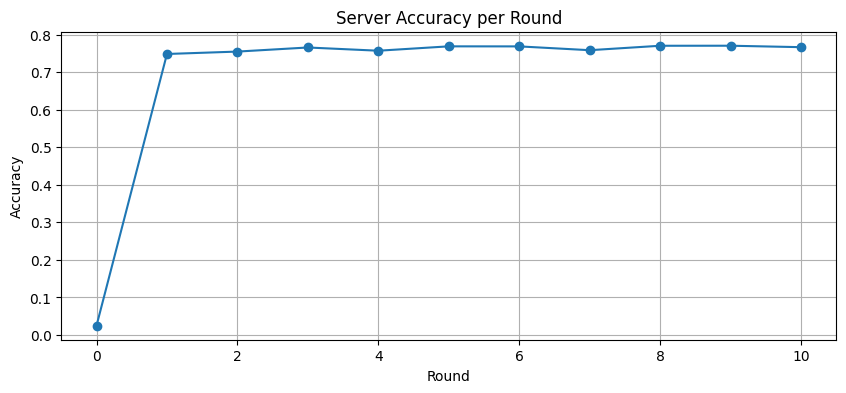

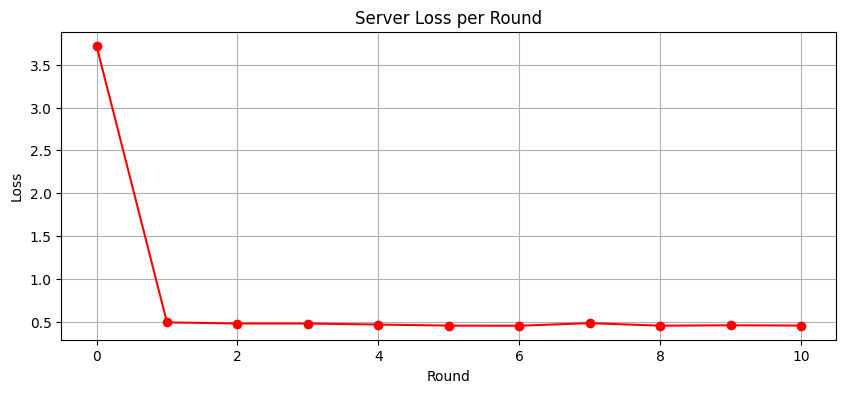

In [ ]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
